# Birmingham B28 Housing Market Analysis

## Table of Contents

[1. Introduction](#1)

[2. Data Processing](#2)

[3. Housing Market Overview and Visualisations](#3)

[4. Property Price Analysis](#4)

[5. Average Property Prices comparing to Birmingham's Average](#5)

[6. Correlation Analysis between Price and other Property characteristics](#6)

[7. Linear Regression Model for Price Prediction](#7)

## 1. Introduction 
<a name="1"></a>

### Purposes of the Analysis:

A research on the housing market to provide the real estate agency manager with insights into housing prices, property types, sizes and features. 
With further investigations aim to analyze: 
- How the local market compares to the wider market?
- Key factors influencing property prices.
- The statistical models to estimate property values based on features like types, size, facilities, and locations.

### The Data Source:

Properties data were collected in December 2024, on [www.righmove.co.uk](www.righmove.co.uk), for all **720** for sale properties within a **1-mile radius** of the **B28** area, **Birmingham, UK**.  

### Data Sampling Method:
Simple random method ultilising pandas method `sample()`: to get a representative sample of **120** properties in **B28** area.

### Limitations:

- **Incorrect or missing data:** Data fields such as Property Address, Number of Bedrooms, Number of Bedrooms, Postcodes, etc. contain typographical errors, missing, or incorrect data.  
- **Lack of detailed property features:** Additional features that potentially affect the price of a property, such as: Furnished Type, Amenities, Property Condition, Size of Bedroom, Size of Living Rooms, etc. were not listed in the webpage, or only optionally mentioned in the description.  
- **Sensitivity to market shifts:** The analysis and the prediction model might be outdated when economic or market conditions change. 
- **Absence of trend analysis:** The analysis does not mention the market trends or seasonal fluctuations in the housing market.

### Transferability:
The method and files for data collection and analysis can be reused for any different areas of any scales in the UK available on [rightmove.co.uk](www.rightmove.co.uk), with appropriate modifications required. 


## 2. Data Preprocessing
<a name="2"></a>

### Import the Dataset and Packages:

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import re
from pandas.api.types import CategoricalDtype
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import math
from matplotlib.ticker import FuncFormatter


In [2]:
# Import the main Dataset
df = pd.read_csv(r'.\datasets\[sample]B28_120_properties.csv')
df_test = pd.read_csv(r'.\datasets\[test_sample]B28_30_properties.csv')

# Drop excessive column due to indexing option of exporting .csv file on previous steps
df.drop('Unnamed: 0', axis = 1, inplace = True)
df_test.drop('Unnamed: 0', axis = 1, inplace = True)

In [3]:
# Dataset inspection:
df.head()

,address,price,type,no_bed,no_bath,agent,url,garden,parking,new_home,postcode,location,latitude,longitude,tenure,to_nearest_station,to_nearest_school,tax_band
0,"Chamberlain Crescent, Shirley, Solihull, B90 2DG",320000,Semi-Detached,3,1,"Arden Estates, Solihull",https://www.rightmove.co.uk/properties/1544876...,True,True,False,B90 2DG,"Chamberlain Crescent, Shirley, Solihull, West ...",52.407107,-1.834241,Freehold,0.5 miles,0.1 miles,Band: C
1,"Dolphin Lane, Birmingham",260000,End of Terrace,3,1,"Manny Klarico, Hall Green",https://www.rightmove.co.uk/properties/1525417...,True,True,False,NaN,"Dolphin Lane, Acocks Green, Fox Hollies, Birmi...",52.438319,-1.827190,Ask agent,0.7 miles,0.1 miles,Band: A
2,"Barrington Road, Olton, Solihull",280000,Semi-Detached,3,1,"Melvyn Danes, Solihull",https://www.rightmove.co.uk/properties/1525876...,True,True,False,NaN,"Barrington Road, Olton, Solihull, West Midland...",52.440330,-1.801880,Freehold,0.2 miles,0.2 miles,Band: C
3,"St. Bernards Road, Olton, Solihull",850000,Detached,5,3,"Andrew Grant, Covering the West Midlands",https://www.rightmove.co.uk/properties/1544543...,True,True,False,NaN,"St Bernards Road, Kineton Green, Solihull, Wes...",52.424862,-1.811723,Freehold,0.1 miles,0.2 miles,NaN
4,"Fircroft, Solihull",550000,Detached,4,2,"Ruxton Independent Estate Agents & Valuers, So...",https://www.rightmove.co.uk/properties/1498761...,True,True,False,NaN,"Fircroft, Ulverley Green, Solihull, West Midla...",52.425536,-1.797471,Freehold,0.8 miles,0.2 miles,Band: F


In [4]:
# Dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   address             120 non-null    object 
 1   price               120 non-null    int64  
 2   type                120 non-null    object 
 3   no_bed              120 non-null    int64  
 4   no_bath             120 non-null    int64  
 5   agent               120 non-null    object 
 6   url                 120 non-null    object 
 7   garden              120 non-null    bool   
 8   parking             120 non-null    bool   
 9   new_home            120 non-null    bool   
 10  postcode            51 non-null     object 
 11  location            120 non-null    object 
 12  latitude            120 non-null    float64
 13  longitude           120 non-null    float64
 14  tenure              120 non-null    object 
 15  to_nearest_station  120 non-null    object 
 16  to_neare

In [5]:
# Dropping 'miles' in the 2 columns: to_nearest_station and to_nearest_school and covert to float on both datasets

# Main dataset
df['to_nearest_station'] = df['to_nearest_station'].str.strip(' miles').astype(float)
df['to_nearest_school'] = df['to_nearest_school'].str.strip(' miles').astype(float)
df['tax_band'] = df['tax_band'].str.replace('Band: ', '')

# Separate Dataset for Testing the Model
df_test['to_nearest_station'] = df_test['to_nearest_station'].str.strip(' miles').astype(float)
df_test['to_nearest_school'] = df_test['to_nearest_school'].str.strip(' miles').astype(float)
df_test['tax_band'] = df_test['tax_band'].str.replace('Band: ', '')

In [6]:
# Get the postcode from the column location
postcode_pattern = r'\b(B\d{1,2}(?: \d\w{2})?)\b'
df['update_postcode'] = df['location'].str.extract(postcode_pattern)

# Update missing postcodes
df['postcode'] = df['postcode'].fillna(df['update_postcode'])
df.drop(columns = 'update_postcode', inplace = True)
df['type'].value_counts()

type
Semi-Detached             41
Terraced                  24
Detached                  23
End of Terrace             8
Apartment                  7
Flat                       6
House                      3
Maisonette                 2
Semi-Detached Bungalow     2
Bungalow                   1
Ground Flat                1
Cottage                    1
Duplex                     1
Name: count, dtype: int64

In [7]:
# Some addtional modifications to the dataframe
df[df['type'] == 'House']

# Update 3 'House' to correct type
df.loc[[23, 34], 'type'] = 'Terraced'
df.loc[42, 'type'] = 'Semi-Detached'

#Group 'Apartment' and 'Flat' and 'Ground Flat':
df['type'] = df['type'].replace('Apartment', 'Flat')
df['type'] = df['type'].replace('Ground Flat', 'Flat')

# Group 'Bungalow' and 'Semi-Detached Bungalow' as 'Bungalow'
df['type'] = df['type'].replace('Semi-Detached Bungalow', 'Bungalow')

# Replace 'Ask agent' in 'tenure' by NaNs
df['tenure'] = df['tenure'].replace('Ask agent', np.nan)

# Correct the types of the Test Dataset
df_test['type'].value_counts()
df_test['type'] = df_test['type'].replace('Apartment', 'Flat')
df_test['type'] = df_test['type'].replace('End of Terrace', 'Terraced')
df_test['type'] = df_test['type'].replace('Link Detached House', 'Detached')

# Create the new column with 4 price ranges: <200k, 200-400k, 400-600k, 600-800k, 800-1000k
bins = [0, 200000, 400000, 600000, 800000, float('inf')]
labels = ['0-200', '200-400', '400-600', '600-800', '800-1000']
df['price_range'] = pd.cut(df['price'], bins=bins, labels=labels, right=False)

# Define the ordered categories
price_range_order = CategoricalDtype(categories=['0-200', '200-400', '400-600', '600-800', '800-1000'])

# Cast the column to the ordinal type
df['price_range'] = df['price_range'].astype(price_range_order)

>We can group 'End of Terrace' and 'Terrace' since they are similar and have relatively close average price, while 'Bungalow', 'Maisonette', 'Cottage', and 'Duplex' will be classified as 'Others' since there are too few observations of them to provide meaningful results or stable estimates.

In [8]:
# Convert the types
df['type'] = df['type'].replace('End of Terrace', 'Terraced')
for _ in ['Bungalow', 'Maisonette', 'Cottage', 'Duplex']:
    df['type'] = df['type'].replace(_, 'Other')

# Export the compelete dataframe for Power BI/Tableau visualisations
df.to_csv(r'.\datasets\Power_BI_data.csv')

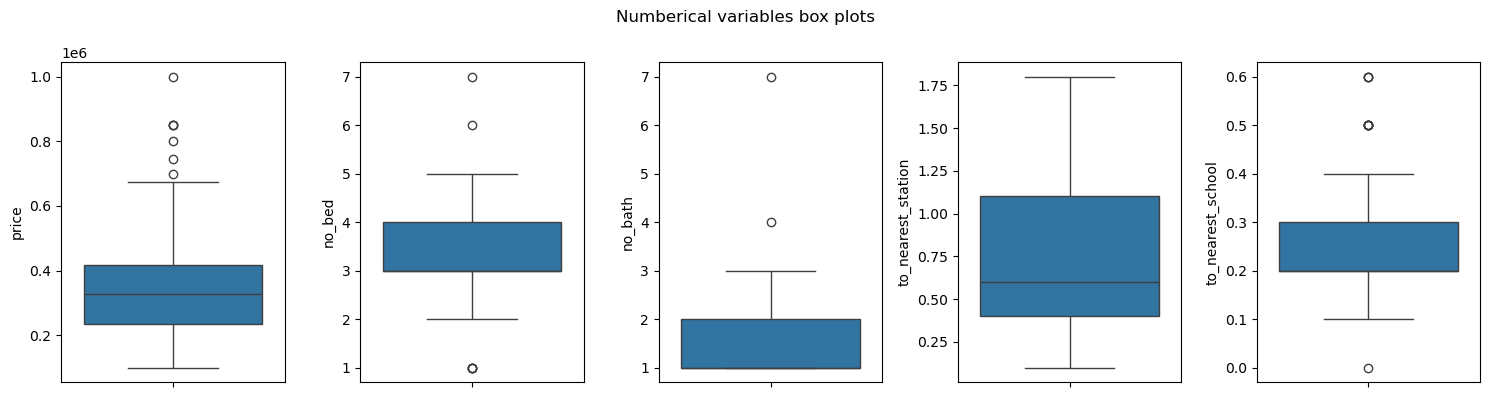

In [9]:
# Outlier Analysis
fig, axs = plt.subplots(1,5, figsize = (15,4))
fig.suptitle('Numberical variables box plots')
plt1 = sns.boxplot(df['price'], ax = axs[0])
plt2 = sns.boxplot(df['no_bed'], ax = axs[1])
plt3 = sns.boxplot(df['no_bath'], ax = axs[2])
plt1 = sns.boxplot(df['to_nearest_station'], ax = axs[3])
plt2 = sns.boxplot(df['to_nearest_school'], ax = axs[4])

plt.tight_layout()

Initially keep all Outliers, because:
- Informative Data: Outliers might represent rare but important cases (e.g., luxury properties in your real estate dataset).
- Real-World Relevance: If your test data or future predictions may include similar outliers, it's important for the model to handle them.
- Statistical Validity: Arbitrarily removing data points without justification can introduce bias.

For later usages of prediction models, excluding outliers will be reconsidered.

## 3. Housing Market Overview and Visualisations
<a name="3"></a>

### Prices Distribution:
- Price of Properties in B28 area is right-skewed.
- Most listings are around **£200,00 to £400,000**.

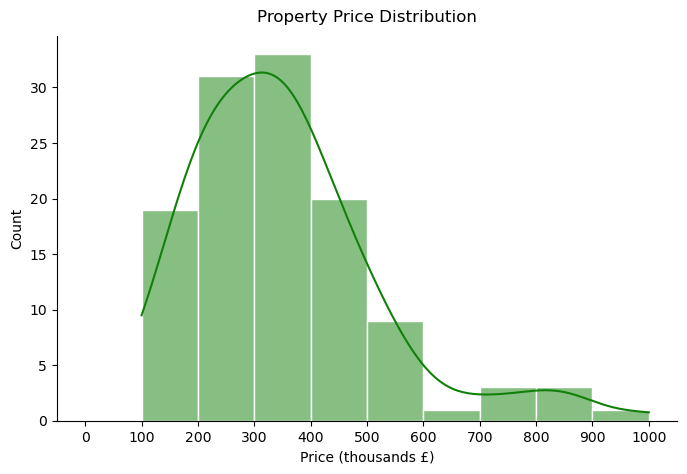

In [10]:
# Plot the histogram
bins = [x for x in range(0, 1000001, 100000)]  # Bins are from 0 to 1000 in steps of 100
plt.figure(figsize=(8, 5))  
ax = sns.histplot(df['price'], bins = bins, 
                  edgecolor = 'white', color = '#118009', kde=True)
plt.title("Property Price Distribution", pad=10)
plt.ylabel('Count')
plt.xlabel('Price (thousands £)')
price_ticks = bins  

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(price_ticks, labels=[p for p in range(0, 1001, 100)])
plt.show()

### Property Types Distribution:
- Most common type: `Semi-Detached` with **42** listings.
- Least common types: `Other` with **7** listings


C:\Users\blueb\AppData\Local\Temp\ipykernel_6980\1973225025.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=df['type'].value_counts().index,


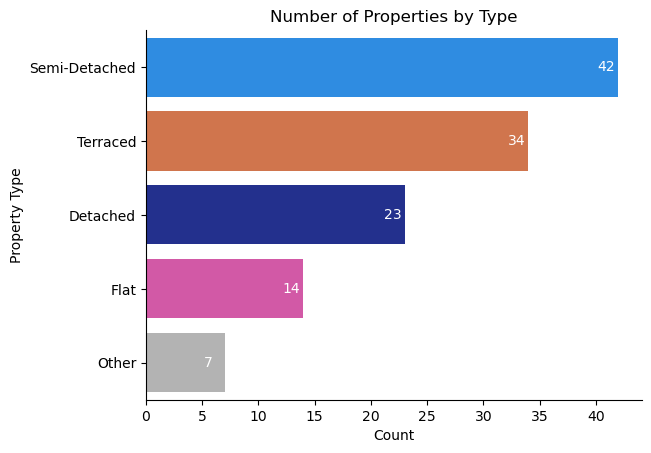

In [11]:
# Create a bar plot of the count of properties by 'type'
ax = sns.barplot(y=df['type'].value_counts().index, 
            x=df['type'].value_counts().values,
            palette = ['#118DFF', '#E66C37', '#12239E', '#E645AB', '#B3B3B3'])

for container in ax.containers:
    ax.bar_label(container, 
                 labels=[f'{int(val)}' for val in container.datavalues],  # Use values of the bars
                 padding=-15,  # Add some space between the bar and the label
                 fontsize=10,  # Font size
                 color='white'  # Label color
                )

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('Count')
plt.ylabel('Property Type')
plt.title('Number of Properties by Type')
plt.show()

### Number of Properties by `Types` and `Price Range`:
- Most common type in the range of **£200K-400K**: `Semi-Detached` with **30** listings.
- Most common type with price **Below 200K**: `Flat` with **10** listings.
- Most common type in high price range of **£400K-1000K**: `Detached` with **20** listings.

C:\Users\blueb\AppData\Local\Temp\ipykernel_6980\4151995970.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_df = df.groupby(['price_range', 'type']).size().reset_index(name='count')


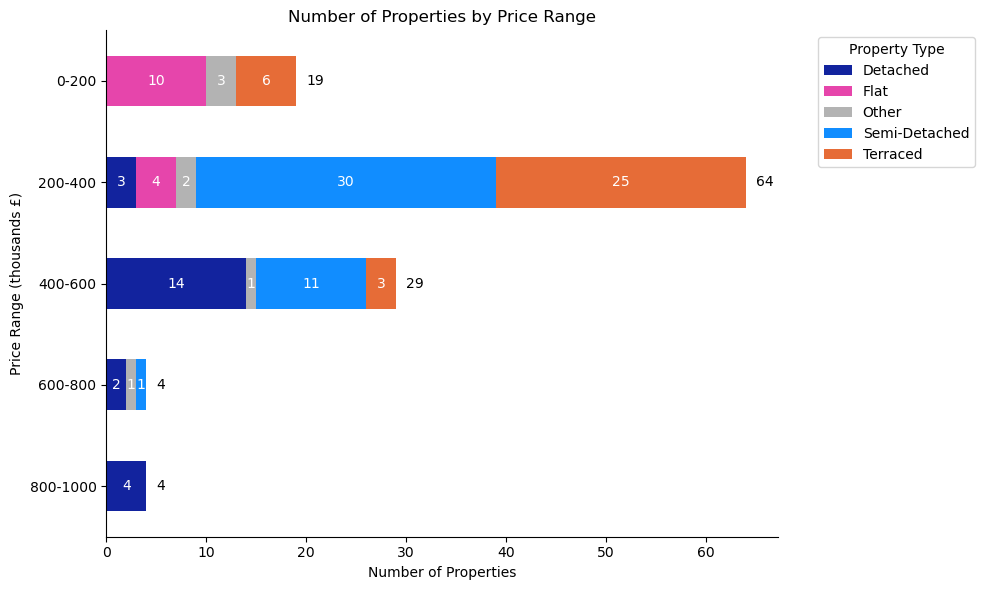

In [12]:
# Preprocessing to create a pivot table for stacked bar plot
count_df = df.groupby(['price_range', 'type']).size().reset_index(name='count')
pivot_df = count_df.pivot(index='price_range', columns='type', values='count').fillna(0)

# Ensuring the order of price ranges
pivot_df = pivot_df.reindex(['800-1000', '600-800', '400-600', '200-400', '0-200'])

# Plotting the stacked bar plot
ax = pivot_df.plot(
    kind='barh',
    stacked=True,
    figsize=(10, 6),
    color = ['#12239E', '#E645AB', '#B3B3B3', '#118DFF', '#E66C37']
)

# Add numbers to the segments
for i, price_range in enumerate(pivot_df.index):
    cumulative_width = 0
    for col in pivot_df.columns:
        value = pivot_df.loc[price_range, col]
        if value > 0:
            # Annotate the segment
            ax.text(
                cumulative_width + value / 2,  # Position: middle of the segment
                i,  # Position: y-coordinate (row index)
                str(int(value)),  # Convert to int for clean display
                va='center',  # Center vertically
                ha='center',  # Center horizontally
                fontsize=10,
                color='white'  # Text color
            )
            cumulative_width += value

    # Add the total value at the end of the bar
    ax.text(
        cumulative_width + 1,  # Slightly offset to the right
        i,  # Position: y-coordinate (row index)
        str(int(cumulative_width)),  # Total value
        va='center',  # Center vertically
        ha='left',  # Align left
        fontsize=10,
        color='black'  # Text color
    )

# Titles and labels
plt.title('Number of Properties by Price Range')
plt.xlabel('Number of Properties')
plt.ylabel('Price Range (thousands £)')
plt.legend(title='Property Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Access the current axis
ax = plt.gca()

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

### Number of properties by `Type`, `Number of Bedrooms` againts `Price Range`:
Regarding Property Types:
- Most `Terraced` properties (**25/28**) have prices around **£200K-400K**.
- Most `Semi-Detached` properties (**30/42**) have prices around **£200K-400K**.
- Most `Detached` properties (**14/23**) have prices around **£400K-600K**.

Regarding Number of Bedrooms:
- Most porperties (**60/120 or 50%**) have **3 bedrooms**, and **45** of them have prices around **£200K-400K**.

C:\Users\blueb\AppData\Local\Temp\ipykernel_6980\2748556084.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = df.groupby(['type', 'price_range']).size().unstack(fill_value=0)


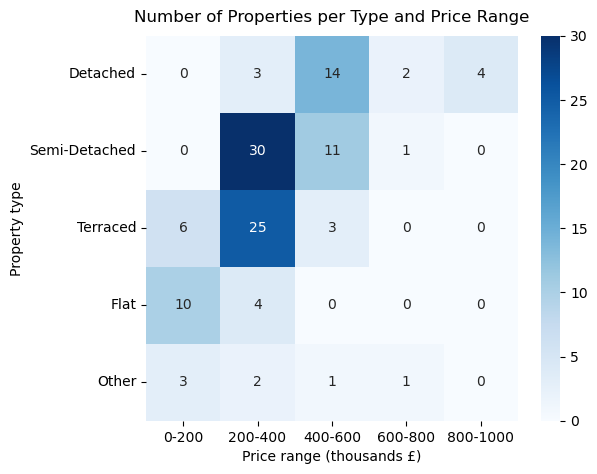

In [13]:
# Count occurrences for each combination
heatmap_data = df.groupby(['type', 'price_range']).size().unstack(fill_value=0)

# Plot the heatmap
# Reorder the rows (y-axis) by a custom order
custom_order = ['Detached', 'Semi-Detached', 'Terraced', 'Flat', 'Other']  # Specify the desired order for Category1
heatmap_data = heatmap_data.reindex(custom_order)

plt.figure(figsize=(6, 5))
sns.heatmap(heatmap_data, annot=True, cmap='Blues', fmt='d')
# Rotate the y-axis labels
plt.yticks(rotation=0)
plt.title('Number of Properties per Type and Price Range', pad=10)
plt.ylabel('Property type')
plt.xlabel('Price range (thousands £)')
plt.show()

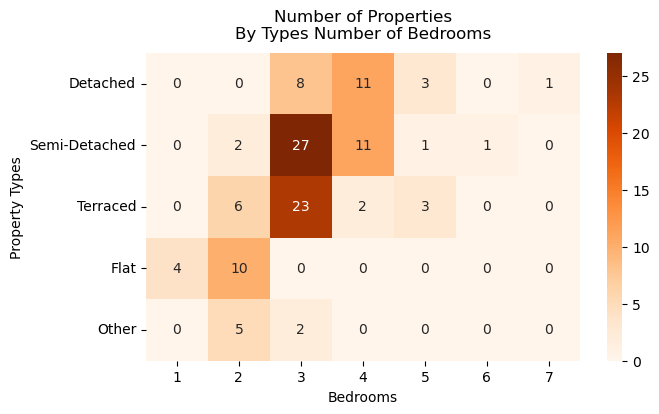

In [14]:
# Count occurrences for each combination
heatmap_data = df.groupby(['type', 'no_bed']).size().unstack(fill_value=0)
custom_order = ['Detached', 'Semi-Detached', 'Terraced', 'Flat', 'Other']  # Specify the desired order for Category1
heatmap_data = heatmap_data.reindex(custom_order)
plt.figure(figsize=(7, 4))
sns.heatmap(heatmap_data, annot=True, cmap='Oranges', fmt='d')
# Rotate the y-axis labels
plt.yticks(rotation=0)
plt.title('Number of Properties\nBy Types Number of Bedrooms', pad=10)
plt.ylabel('Property Types')
plt.xlabel('Bedrooms')
plt.show()

C:\Users\blueb\AppData\Local\Temp\ipykernel_6980\4180142242.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=heatmap_data.applymap(format_currency),


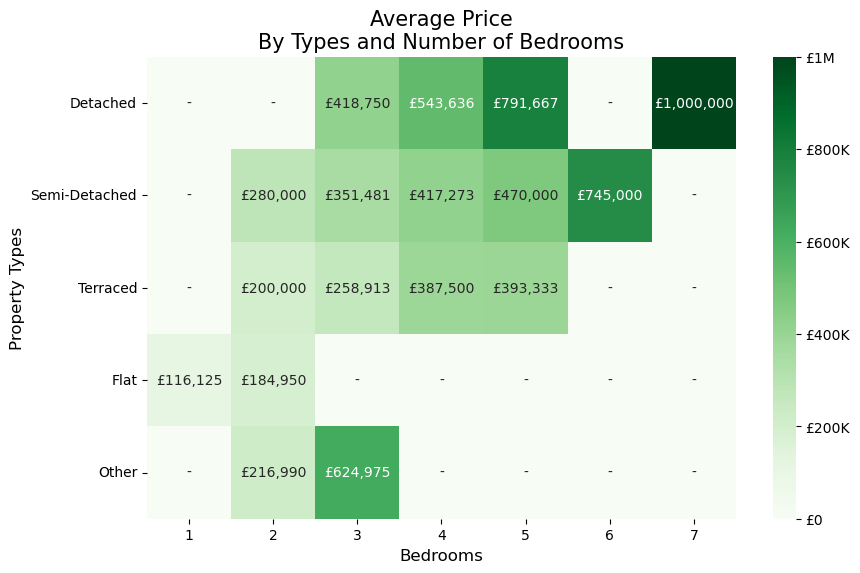

In [15]:
# mean for each combination
heatmap_data = df.groupby(['type', 'no_bed'])['price'].mean().unstack(fill_value=0)


plt.figure(figsize=(9.5, 6))
def format_currency(value):
    if value == 0:
        return_val = "-"
    else:
        return_val = f"£{value:,.0f}" 
    return return_val   # Adds pound sign and thousands separator

custom_order = ['Detached', 'Semi-Detached', 'Terraced', 'Flat', 'Other']  # Specify the desired order for Category1
heatmap_data = heatmap_data.reindex(custom_order)
ax = sns.heatmap(heatmap_data, 
            annot=heatmap_data.applymap(format_currency), 
            cmap='Greens', fmt='',
            cbar_kws={
            "ticks": [0, 200000, 400000, 600000, 800000, 1000000]  # Custom tick locations
    })

# Access the color bar and set custom tick labels
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0, 200000, 400000, 600000, 800000, 1000000])
colorbar.set_ticklabels(['£0', '£200K', '£400K', '£600K', '£800K', '£1M'])

# Rotate the y-axis labels
plt.yticks(rotation=0)
plt.title('Average Price\nBy Types and Number of Bedrooms', fontsize = 15)
plt.ylabel('Property Types', fontsize = 12)
plt.xlabel('Bedrooms', fontsize = 12)
plt.show()

### Garden, Parking and New home Percentages:

In [16]:
def percentage(checking_var, checking_val):
    '''Find Percentage of "True" of a particular variable in the dataset

    Arguments:
        checking_var -- the targeted variables 
        checking_var -- the compared value

    Returns:
        None
    '''
    percentage = df[df[checking_var] == checking_val].shape[0]/df.shape[0]
    print(f'The Precentage of {checking_val} in {checking_var} is {percentage*100:.1f}%')
 
# Percentages of Houses with Garden, Parking, or is New Home:    
percentage('garden', True)
percentage('parking', True)
percentage('new_home', True)

The Precentage of True in garden is 90.0%
The Precentage of True in parking is 89.2%
The Precentage of True in new_home is 3.3%


In [55]:
# Percentage of Tenure
percentage('tenure', 'Freehold')
percentage('tenure', 'Leasehold')

The Precentage of Freehold in tenure is 82.5%
The Precentage of Leasehold in tenure is 14.2%


### Distances to Nearest Schools and Stations:

In [18]:
# Distance to nearest school stats:
df['to_nearest_school'].describe()

count    120.000000
mean       0.234167
std        0.121956
min        0.000000
25%        0.200000
50%        0.200000
75%        0.300000
max        0.600000
Name: to_nearest_school, dtype: float64

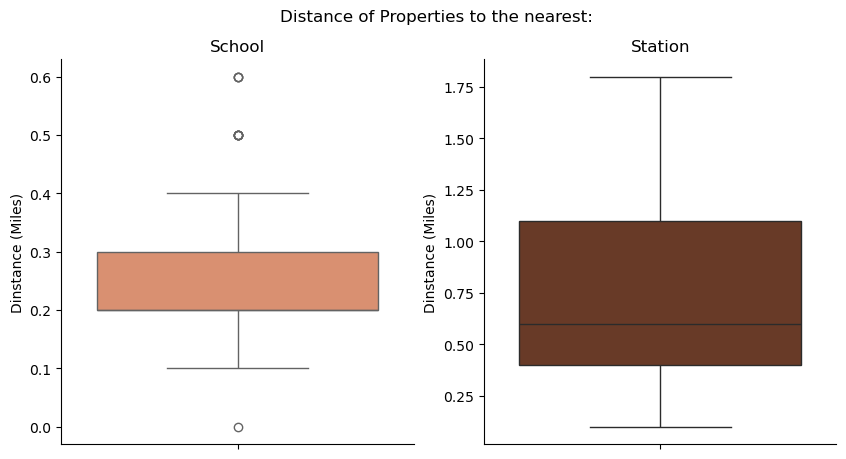

<Figure size 800x600 with 0 Axes>

In [ ]:
#
fig, axs = plt.subplots(1, 2, figsize = (10 ,5))
plt.figure(figsize=(8, 6))
# Plot names
box_name = ['School',
            'Station']

# Visualise the plots
for i, (var, clr, name)  in enumerate(zip(['to_nearest_school', 'to_nearest_station'], ['#EB895F', '#73361C'], box_name)):
    sns.boxplot(data = df[var], 
                color = clr,
                ax = axs[i],
                )  # Remove confidence interval)
    axs[i].set_ylabel('Dinstance (Miles)')
    axs[i].set_xlabel('')
    axs[i].set_title(name)
    # Remove top and right spines
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)    

fig.suptitle('Distance of Properties to the nearest:');

In [19]:
# Distance to nearest station stats:
df['to_nearest_station'].describe()

count    120.000000
mean       0.705833
std        0.417334
min        0.100000
25%        0.400000
50%        0.600000
75%        1.100000
max        1.800000
Name: to_nearest_station, dtype: float64

## 4. Property Price Analysis
<a name="4"></a>

### Descriptive Statistics of Property `Price`:

In [56]:
# Descriptive Statistics of Property Price
df['price'].describe()

count        120.000000
mean      352657.500000
std       167940.641481
min       100000.000000
25%       233750.000000
50%       327500.000000
75%       418750.000000
max      1000000.000000
Name: price, dtype: float64

### Descriptive Statistics of `Price` by `Prorperty Type`:
- Except `Other` with multiples different uncommon types, `Detached` properties show the largest spead in their prices with Price Standard Deviation of **184019.94**. Implying this type can be found in different price ranges. 
-  `Detached` properties also show the highest average price with **£552391.3**.
-  `Flat` show the smallest average price and standard deviations. Thus, it is expected that any Flat in the area will have their price in the lowest range. 

In [57]:
# Descriptive Statistics by Property Types
pd.options.display.width = 200 # Adjust display width
price_stats_by_type = df.groupby('type')['price'].describe()

print(price_stats_by_type)

               count           mean            std       min       25%       50%       75%        max
type                                                                                                 
Detached        23.0  552391.304348  184019.944356  300000.0  425000.0  500000.0  625000.0  1000000.0
Flat            14.0  165285.714286   39139.157201  100000.0  129625.0  177500.0  197500.0   215000.0
Other            7.0  333557.142857  235602.925895  135000.0  187475.0  200000.0  412500.0   799950.0
Semi-Detached   42.0  377500.000000   95261.194208  250000.0  325000.0  352500.0  400000.0   745000.0
Terraced        34.0  267941.176471   78760.450457  120000.0  221250.0  255000.0  290000.0   465000.0


C:\Users\blueb\AppData\Local\Temp\ipykernel_14772\1974722392.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='type', y='price', data=df, palette = type_color)


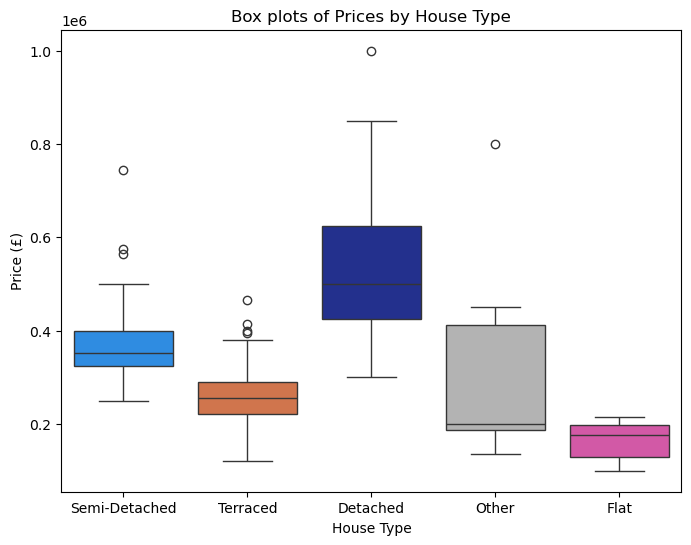

In [58]:
type_color = ['#118DFF', '#E66C37', '#12239E', '#B3B3B3', '#E645AB']

plt.figure(figsize=(8, 6))
sns.boxplot(x='type', y='price', data=df, palette = type_color)
plt.title('Box plots of Prices by House Type')
plt.ylabel('Price (£)')
plt.xlabel('House Type')
plt.show()

### Descriptive Statistics of `Price` by `Number of Bedrooms`:
As the `Number of Bedrooms` increases, its price and its spread also increase.

In [59]:
# Descriptive Statistics by Bedroom number
price_stats_by_no_bed = df.groupby('no_bed')['price'].describe().T
print(price_stats_by_no_bed)

no_bed             1              2              3              4              5         6          7
count        4.00000      23.000000      60.000000      24.000000       7.000000       1.0        1.0
mean    116125.00000  204106.521739  334082.500000  472708.333333  575000.000000  745000.0  1000000.0
std      13603.76786   56899.988625  104806.358499  122802.237328  213150.963717       NaN        NaN
min     100000.00000  120000.000000  180000.000000  300000.000000  365000.000000  745000.0  1000000.0
25%     107500.00000  175000.000000  263750.000000  391250.000000  407500.000000  745000.0  1000000.0
50%     117500.00000  199950.000000  325000.000000  447500.000000  470000.000000  745000.0  1000000.0
75%     126125.00000  212500.000000  375000.000000  527500.000000  762500.000000  745000.0  1000000.0
max     129500.00000  375000.000000  799950.000000  850000.000000  850000.000000  745000.0  1000000.0


C:\Users\blueb\AppData\Local\Temp\ipykernel_14772\860967198.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='no_bed', y='price', data=df, palette='Oranges')


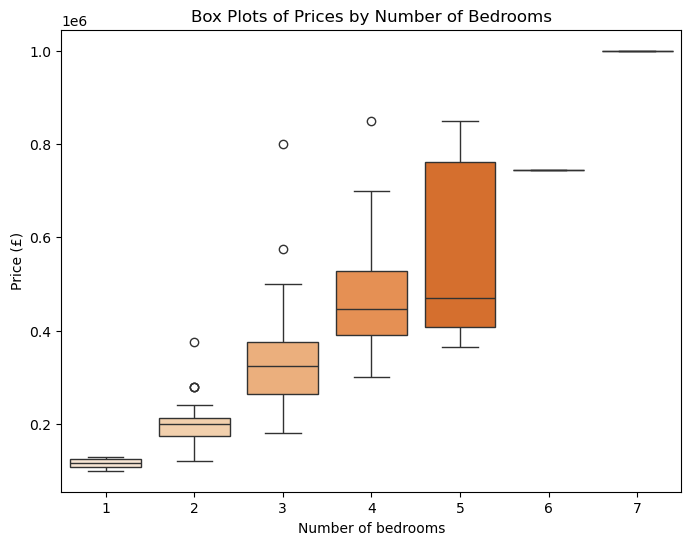

In [137]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='no_bed', y='price', data=df, palette='Oranges')
plt.title('Box Plots of Prices by Number of Bedrooms')
plt.ylabel('Price (£)')
plt.xlabel('Number of bedrooms')
plt.show()

### 95% Confidence Interval (CI) of the `Average house Price`:

**Confidence Interval**

Assuming that the housing prices are normally distributed. Estimate the actual average property price with 95% confidence level. 

The degree of accuracy (z-value) which reflect the confidence level will be 1.96. 

The statistical table provide information about the sample mean, standard deviation and the sample size.  While CI is given by: 

$$
\bar{x} - z_{\frac{\alpha}{2}} \frac{\sigma}{\sqrt{n}} \leq \mu \leq \bar{x} + z_{\frac{\alpha}{2}} \frac{\sigma}{\sqrt{n}}
$$


In [61]:
# average price of each types
df_type_price = df.groupby('type')['price'].mean()
df_type_price

type
Detached         552391.304348
Flat             165285.714286
Other            333557.142857
Semi-Detached    377500.000000
Terraced         267941.176471
Name: price, dtype: float64

In [62]:
# std dev price of each types
df_type_price = df.groupby('type')['price'].std()
df_type_price

type
Detached         184019.944356
Flat              39139.157201
Other            235602.925895
Semi-Detached     95261.194208
Terraced          78760.450457
Name: price, dtype: float64

#### CI of a Typical Property:

In [63]:
# 95% CI of a Typical Property:

sample_prices = df['price']

# Calculate the sample mean and standard error
mean_price = np.mean(sample_prices)
std_dev = np.std(sample_prices)
std_error = np.std(sample_prices, ddof=1) / np.sqrt(len(sample_prices))

# For a 95% confidence interval, use the z-score for a normal distribution
z_score = stats.norm.ppf(0.975)  # For 95% CI, we use 0.975 for two-tailed CI

# Calculate the margin of error
margin_of_error = z_score * std_error

# Calculate the confidence interval
lower_bound = mean_price - margin_of_error
upper_bound = mean_price + margin_of_error

print(" - 95% CI of sample Price:")
print(f"  MoE: {margin_of_error}")
print(f"  Mean Price: {mean_price:.2f}, Standard Deviation: {std_dev:.2f} ")
print(f"  95% CI: [{lower_bound:.2f}; {upper_bound:.2f}]")
print("\n")

 - 95% CI of sample Price:
  MoE: 30047.84122292398
  Mean Price: 352657.50, Standard Deviation: 167239.42 
  95% CI: [322609.66; 382705.34]




#### CI of `Semi-Detached`, and `Terraced` Prices

In [64]:
# z-stats: CI of Semi-Detached, and Terraced

for property_type in ['Semi-Detached', 'Terraced']:
    prices = df[df['type'] == property_type]['price'].dropna()

    # Calculate the sample mean and standard error
    mean_price = np.mean(prices)
    std_dev = np.std(prices)
    std_error = np.std(prices, ddof=1) / np.sqrt(len(prices))

    # For a 95% confidence interval, use the z-score for a normal distribution
    z_score = stats.norm.ppf(0.975)  # For 95% CI, we use 0.975 for two-tailed CI

    # Calculate the margin of error
    margin_of_error = z_score * std_error

    # Calculate the confidence interval
    lower_bound = mean_price - margin_of_error
    upper_bound = mean_price + margin_of_error

    print(f"- {property_type}:")
    print(f"  Mean Price: {mean_price:.2f}, Standard Deviation: {std_dev:.2f} ")
    print(f"  MoE: {margin_of_error}")
    print(f"  95% CI: [{lower_bound:.2f}; {upper_bound:.2f}]")
    print("\n")

- Semi-Detached:
  Mean Price: 377500.00, Standard Deviation: 94120.30 
  MoE: 28809.748524269588
  95% CI: [348690.25; 406309.75]


- Terraced:
  Mean Price: 267941.18, Standard Deviation: 77593.56 
  MoE: 26473.832932465186
  95% CI: [241467.34; 294415.01]




#### CI of `Detached`, `Flat` and `Other` Prices

In [65]:
for property_type in ['Detached', 'Flat', 'Other']:
    prices = df[df['type'] == property_type]['price'].dropna()

    n = len(prices)  # Sample size
    mean = np.mean(prices)  # Sample mean
    sem = np.std(prices, ddof=1) / np.sqrt(n)  # Standard error of the mean (using ddof=1 for sample std)

    # Step 2: Determine the t-value for 95% confidence level
    confidence = 0.95
    alpha = 1 - confidence
    t_value = stats.t.ppf(1 - alpha / 2, df=n-1)  # Two-tailed t-value

    # Step 3: Compute margin of error
    margin_of_error = t_value * sem

    # Step 4: Construct the confidence interval
    lower_bound = mean - margin_of_error
    upper_bound = mean + margin_of_error


    print(f"- {property_type}:")
    print(f'  t = {t_value}')
    print(f"  MOE: {margin_of_error:.2f}")
    print(f"  Mean Price: {mean:.2f}, Standard Deviation: {std_dev:.2f} ")
    print(f"  MoE: {margin_of_error}")
    print(f"  95% CI: ({lower_bound:.2f}, {upper_bound:.2f})")

- Detached:
  t = 2.0738730679040147
  MOE: 79576.19
  Mean Price: 552391.30, Standard Deviation: 77593.56 
  MoE: 79576.19126170018
  95% CI: (472815.11, 631967.50)
- Flat:
  t = 2.1603686564610127
  MOE: 22598.28
  Mean Price: 165285.71, Standard Deviation: 77593.56 
  MoE: 22598.276569996044
  95% CI: (142687.44, 187883.99)
- Other:
  t = 2.4469118511449692
  MOE: 217896.36
  Mean Price: 333557.14, Standard Deviation: 77593.56 
  MoE: 217896.36430565675
  95% CI: (115660.78, 551453.51)


In [66]:
# type order:
type_order = ['Detached', 'Semi-Detached', 'Terraced', 'Flat', 'Other']
df_type_price = df_type_price[type_order]

In [67]:
means_type= [552391.30, 377500.00, 267941.18, 165285.71, 333557.14]
lower_bounds_type = [472815.11, 348690.25, 241467.34, 142687.44, 115660.78]
upper_bounds_type = [631967.50, 406309.75, 294415.01, 187883.99, 551453.51]

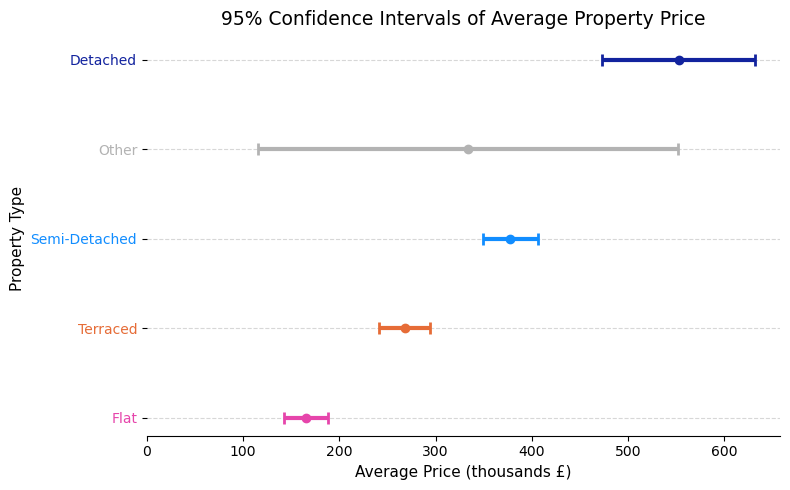

In [68]:
import itertools
# Ploting
# Calculate asymmetric errors
yerr_lower = np.array([means_type[i] - lower_bounds_type[i] for i in range(len(means_type))])
yerr_upper = np.array([upper_bounds_type[i] - means_type[i] for i in range(len(means_type))])

# Define custom order for property types
custom_order = ['Detached', 'Other', 'Semi-Detached' ,'Terraced', 'Flat']
custom_order = custom_order[::-1]

# x axis price ticks
price_ticks = [x for x in range(0, 600001, 100000)]  # Bins are from 0 to 1000 in steps of 100

# Rearrange the data according to the custom order
type_order_custom = custom_order
means_type_custom = [means_type[type_order.index(property_type)] for property_type in custom_order]
yerr_lower_custom = [yerr_lower[type_order.index(property_type)] for property_type in custom_order]
yerr_upper_custom = [yerr_upper[type_order.index(property_type)] for property_type in custom_order]

# Use a colormap to generate colors
colors = itertools.cycle(['#E645AB', '#E66C37', '#118DFF', '#B3B3B3', '#12239E'])

# Plotting with custom order
plt.figure(figsize=(8, 5))
for i in range(len(type_order)):
    plt.errorbar(means_type_custom[i], type_order_custom[i], 
                 xerr=[[yerr_lower_custom[i]], [yerr_upper_custom[i]]], 
                capsize=4, capthick=2, label=f'{type_order[i]}', color=next(colors), 
                linewidth=3, fmt = 'o')
    
    # Apply custom colors to y-tick labels
ax = plt.gca()  # Get current axes
for label, color in zip(ax.get_yticklabels(), colors):
    label.set_color(color)
    
# Add labels and title
plt.title('95% Confidence Intervals of Average Property Price', fontsize = 13.5, pad = 12)
plt.ylabel('Property Type', fontsize = 11)
plt.xlabel('Average Price (thousands £)', fontsize = 11)

# Hide only the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
# Hide y-tick marks but keep the label and grid lines
plt.grid(axis='y', linestyle='--', alpha=0.5)



plt.xticks(price_ticks, labels=[p for p in range(0, 601, 100)], alpha = 1)
plt.tight_layout()
plt.show()
plt.show()

#### Conclusion:
- Except `Other` with multiples different uncommon types, `Detached` properties show the largest spead in their Confidence Interval of their prices with. Suggesting high uncertainty in the true average price of this type. 
-  `Flat`, `Semi-Detached` and `Terraced` show small deviations in their Confidence Interval of average price.

## 5. Average Property Prices comparing to Birmingham's Average
<a name="5"></a>

According to: https://www.ons.gov.uk/visualisations/housingpriceslocal/E08000025/

The provisional average house price in **Birmingham** in August 2024 was **£234,000**.

For each property type, average prices as of August 2024 in Birmingham were:

- `Detached` properties: **£434,000**
- `Semi-detached` properties: **£268,000**
- `Terraced` properties: **£215,000**
- `Flats` and maisonettes: **£159,000**

Average housing prices in **B28** area: 

In [69]:
print("B28 AREA:")
print (f'- Average Price of 120 sampled Properties: {df['price'].mean()}')
for pr_type in df['type'].unique():
    print(f'- Number of {pr_type}: {len(df[df['type'] == pr_type])},  Average Price: {df[df['type'] == pr_type]['price'].mean()}')

B28 AREA:
- Average Price of 120 sampled Properties: 352657.5
- Number of Semi-Detached: 42,  Average Price: 377500.0
- Number of Terraced: 34,  Average Price: 267941.17647058825
- Number of Detached: 23,  Average Price: 552391.304347826
- Number of Other: 7,  Average Price: 333557.14285714284
- Number of Flat: 14,  Average Price: 165285.7142857143


For Hypothesis testing, `Semi-Detached` and `Terraced` can use z-test while `Detached` and `Flat` use t-test (sample size < 30):

- Null Hypothesis (H0): Average(B28 price) = Average(Birmingham price)
- Alternative Hypothesis (Ha): Average(B28 price) > Average(Birmingham price)

With significance level (alpha) of 5%.

### z-test on the Typical Property Average Price

In [70]:
# 1. Calculate the sample mean and sample size
sample_data = df['price']
sample_mean = np.mean(sample_data)
n = len(sample_data)

# 2. Calculate the population standard deviation (or use sample standard deviation if population SD is unknown)
# If population standard deviation is known, replace 'sample_std' with that value
sample_std = np.std(sample_data, ddof=1)  # Sample standard deviation (use ddof=1 for sample)

# 3. Hypothesized population mean
mu_0 = 234000

# 4. Calculate the z-statistic
z_stat = (sample_mean - mu_0) / (sample_std / np.sqrt(n))

# 5. Calculate the p-value for a right-tailed test (since we are testing if the mean is greater)
p_value = 1 - stats.norm.cdf(z_stat)

# 6. Decide based on significance level (e.g., alpha = 0.05)
alpha = 0.05
z_critical = stats.norm.ppf(1 - alpha)

# Output the results
print(f"Z-statistic: {z_stat}")
print(f"P-value: {p_value}")

if p_value < alpha:
    print("Reject the null hypothesis: The mean is significantly greater than 234,000.")
else:
    print("Fail to reject the null hypothesis: The mean is not significantly greater than 234,000.")

Z-statistic: 7.739804825583754
P-value: 4.9960036108132044e-15
Reject the null hypothesis: The mean is significantly greater than 234,000.


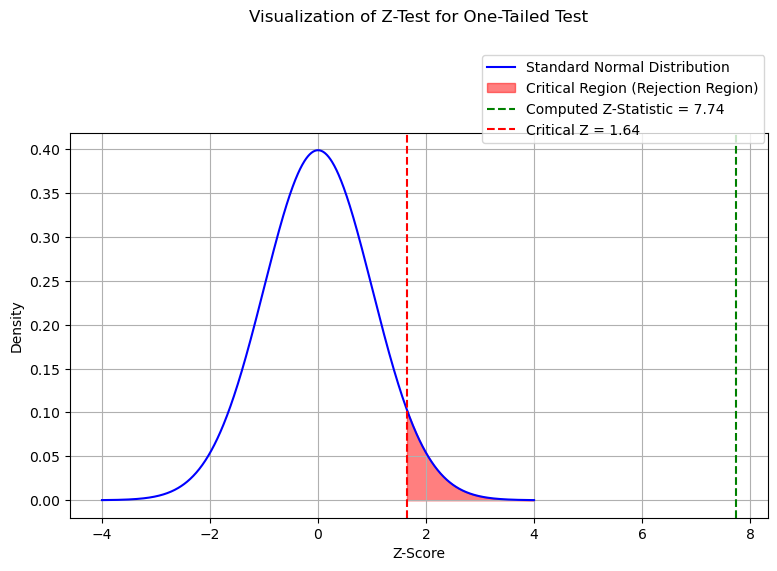

In [71]:
# Set up the x values for the z-distribution (range of z-scores)
x = np.linspace(-4, 4, 1000)
y = stats.norm.pdf(x, 0, 1)

# Create the plot
plt.figure(figsize=(9, 5))
plt.plot(x, y, label="Standard Normal Distribution", color="blue")

# Fill the area to the right of the critical z-value
plt.fill_between(x, y, where=(x >= z_critical), color="red", alpha=0.5, label="Critical Region (Rejection Region)")

# Plot the computed z-statistic
plt.axvline(x=z_stat, color='green', linestyle='--', label=f"Computed Z-Statistic = {z_stat:.2f}")

# Mark the critical value
plt.axvline(x=z_critical, color='red', linestyle='--', label=f"Critical Z = {z_critical:.2f}")

# Labels and title
plt.title("Visualization of Z-Test for One-Tailed Test", pad = 80)
plt.xlabel("Z-Score")
plt.ylabel("Density")
plt.legend(loc='upper right', bbox_to_anchor=(1.005, 1.22))

# Show plot
plt.grid(True)
plt.show()


### z-test on `Semi-Detached` and `Terraced`

In [72]:
population_means_per_type = {
    'Detached': 434000,
    'Semi-Detached': 268000,
    'Terraced': 215000,
    'Flat': 159000
}

for type in ['Semi-Detached', 'Terraced']:
    sample_data = df[df['type'] == type]['price']
    
    # 1. Calculate the sample mean and sample size
    sample_mean = np.mean(sample_data)
    n = len(sample_data)

    # 2. Calculate the population standard deviation (or use sample standard deviation if population SD is unknown)
    # If population standard deviation is known, replace 'sample_std' with that value
    sample_std = np.std(sample_data, ddof=1)  # Sample standard deviation (use ddof=1 for sample)

    # 3. Hypothesized population mean
    mu_0 = population_means_per_type[type]

    # 4. Calculate the z-statistic
    z_stat = (sample_mean - mu_0) / (sample_std / np.sqrt(n))

    # 5. Calculate the p-value for a right-tailed test (since we are testing if the mean is greater)
    p_value = 1 - stats.norm.cdf(z_stat)

    # 6. Decide based on significance level (e.g., alpha = 0.05)
    alpha = 0.05
    z_critical = stats.norm.ppf(1 - alpha)

    # Output the results
    print(f'- Property type: {type}')
    print(f"  Z-statistic: {z_stat}")
    print(f"  P-value: {p_value}")

    if p_value < alpha:
        print(f"  Reject the null hypothesis: The mean is significantly greater than {mu_0}.")
    else:
        print(f"  Fail to reject the null hypothesis: The mean is not significantly greater than {mu_0}.")
        
    print('-' * 80)


- Property type: Semi-Detached
  Z-statistic: 7.4494248405653885
  P-value: 4.6851411639181606e-14
  Reject the null hypothesis: The mean is significantly greater than 268000.
--------------------------------------------------------------------------------
- Property type: Terraced
  Z-statistic: 3.919447533201236
  P-value: 4.437608934437787e-05
  Reject the null hypothesis: The mean is significantly greater than 215000.
--------------------------------------------------------------------------------


### t-test on `Detached` and `Flat`

In [73]:
for type in ['Detached', 'Flat']:
    sample_data = df[df['type'] == type]['price']
    # Calculate sample statistics
    sample_mean = np.mean(sample_data)
    population_mean =  population_means_per_type[type] # Hypothesized mean
    sample_std = np.std(sample_data, ddof=1)  # Sample standard deviation
    n = len(sample_data)
    degrees_of_freedom = n - 1

    # Calculate t-statistic
    t_stat = (sample_mean - population_mean) / (sample_std / np.sqrt(n))

    # Find the critical t-value for a one-tailed test at alpha = 0.05
    alpha = 0.05
    critical_t_value = stats.t.ppf(1 - alpha, df=degrees_of_freedom)  # One-tailed
    
     # Calculate the one-tailed p-value
    p_value = 1 - stats.t.cdf(t_stat, df=degrees_of_freedom)

    # Print results
    print(f'- Property type: {type}')
    print(f"  t-statistic: {t_stat:.4f}")
    print(f"  p-value (one-tailed): {p_value:.4f}")
    print(f"  Critical t-value (one-tailed, alpha=0.05): {critical_t_value:.4f}")

    # Decision
    alpha = 0.05  # Significance level
    if p_value < alpha:
        print(f"  Reject the null hypothesis: The mean property price is significantly greater than {population_means_per_type[type]}.")
    else:
        print(f"  Fail to reject the null hypothesis: There is not enough evidence to conclude the mean property price is greater than {population_means_per_type[type]}.")

- Property type: Detached
  t-statistic: 3.0855
  p-value (one-tailed): 0.0027
  Critical t-value (one-tailed, alpha=0.05): 1.7171
  Reject the null hypothesis: The mean property price is significantly greater than 434000.
- Property type: Flat
  t-statistic: 0.6009
  p-value (one-tailed): 0.2791
  Critical t-value (one-tailed, alpha=0.05): 1.7709
  Fail to reject the null hypothesis: There is not enough evidence to conclude the mean property price is greater than 159000.


### Conclusion:
- The Average Property Price in **B28** area is significantly **greater** than **Birmingham’s average**, across all types except `Flat`.

## 6. Correlation Analysis between Price and other Property characteristics
<a name="6"></a>

- `Number of bedrooms`, and `Council Tax Band` have strong possitive correlation (`0.76` and `0.86`) with `price` (0.7 ≤ r < 1)
- `Number of bathrooms`, whether or not a property is `Detached`, and whether a property's tenure is `Freehold` depict Moderate Possitive Correlation with `price` (0.3 ≤ r < 0.7)
- Conversely, whether or not a property is a `Flat` or `Terraced` moderately negatively correlated with the `price` (-0.7 < r ≤ -0.3)
- Suprisingly, whether a property have a `garden`, `parking`, and its distance to the nearest station doesn't seem to significantly affect the `price`. This might due to the large proportions of properties in this area have these feature and have the distance <0.5 miles to the closest stations. Furthermore, there're almost no correlation between distance to the closest school.
- In conclusion, the most important factors that affect a property's price:
  - Number of Bedrooms.
  - Number of Bathrooms.
  - Council Tax Band Rate.
  - Tenure.

### The Correlation Matrix:

In [74]:
# the data frame with variables used for correlation matrix
df_cor = df[['price', 'type', 'no_bed', 'no_bath', 'garden', 'parking','new_home','tenure','to_nearest_station','to_nearest_school', 'tax_band']]

In [75]:
#drop the rows with NaNs in 'tenure'
df_cor.dropna(inplace=True)

# Drop rows where tax_band is 'TBC'
df_cor = df_cor[df_cor['tax_band'] != 'TBC']
df_cor = df_cor.reset_index(drop = True)

C:\Users\blueb\AppData\Local\Temp\ipykernel_14772\2171767488.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cor.dropna(inplace=True)


In [76]:
# Mapping of tax bands to numeric values
tax_band_mapping = {
    'A'     : 1,
    'B'     : 2,
    'C'     : 3,
    'D'     : 4,
    'E'     : 5,
    'F'     : 6,
    'G'     : 7,
    'H'     : 8,
}
# Apply the mapping
df_cor['tax_band_encoded'] = df_cor['tax_band'].map(tax_band_mapping)
df_cor.drop(columns='tax_band', inplace=True)

# Create the encoder
encoder_corr = OneHotEncoder(sparse_output=False)  # Set drop='first' to drop the first category as baselines
encoded_data_corr = encoder_corr.fit_transform(df_cor[['type', 'tenure']])
encoded_df_corr = pd.DataFrame(encoded_data_corr, columns=encoder_corr.get_feature_names_out(['type', 'tenure']))
df_corr = pd.concat([df_cor.drop(columns=['type', 'tenure']), encoded_df_corr], axis=1)

#dropping 'new_home' as there're no new_home in the cleaned dataframe
df_corr.drop(columns='new_home', inplace=True)

print(df_corr)

     price  no_bed  no_bath  garden  parking  to_nearest_station  to_nearest_school  tax_band_encoded  type_Detached  type_Flat  type_Other  type_Semi-Detached  type_Terraced  tenure_Freehold  \
0   320000       3        1    True     True                 0.5                0.1                 3            0.0        0.0         0.0                 1.0            0.0              1.0   
1   280000       3        1    True     True                 0.2                0.2                 3            0.0        0.0         0.0                 1.0            0.0              1.0   
2   550000       4        2    True     True                 0.8                0.2                 6            1.0        0.0         0.0                 0.0            0.0              1.0   
3   700000       4        2    True     True                 1.2                0.2                 6            1.0        0.0         0.0                 0.0            0.0              1.0   
4   395000       4       

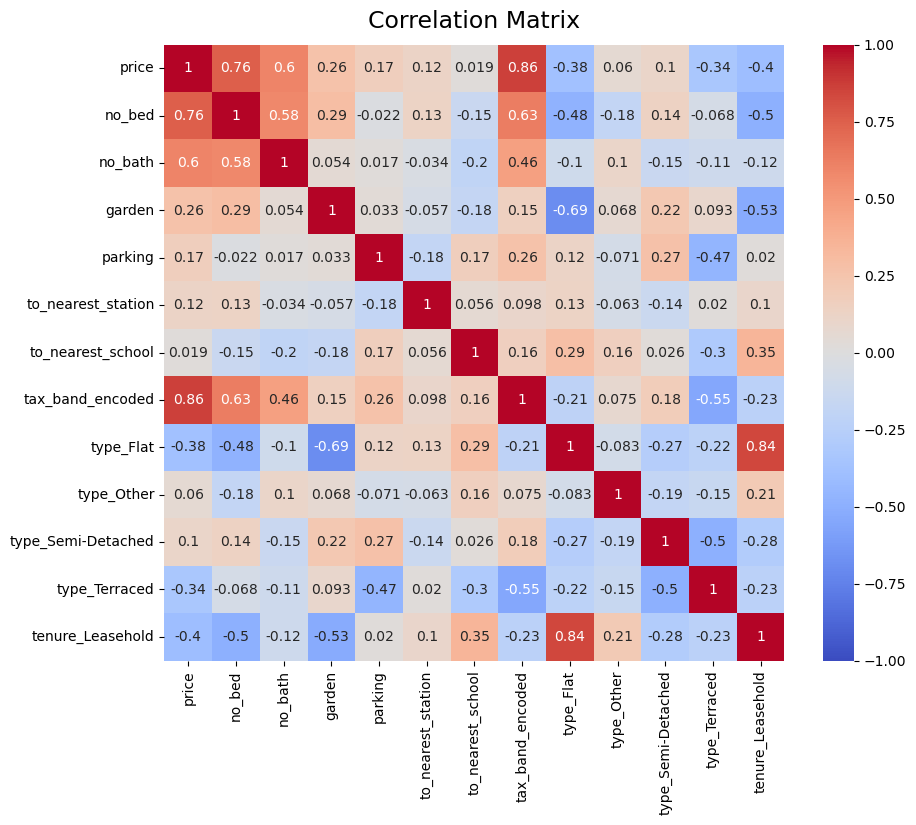

In [77]:
# Calculate the correlation matrix
corr_matrix = df_corr.drop(columns=['type_Detached', 'tenure_Freehold']).corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix', fontsize = 17, pad = 12)
plt.show()

### Scatter plots of most influential variables to `Price`:

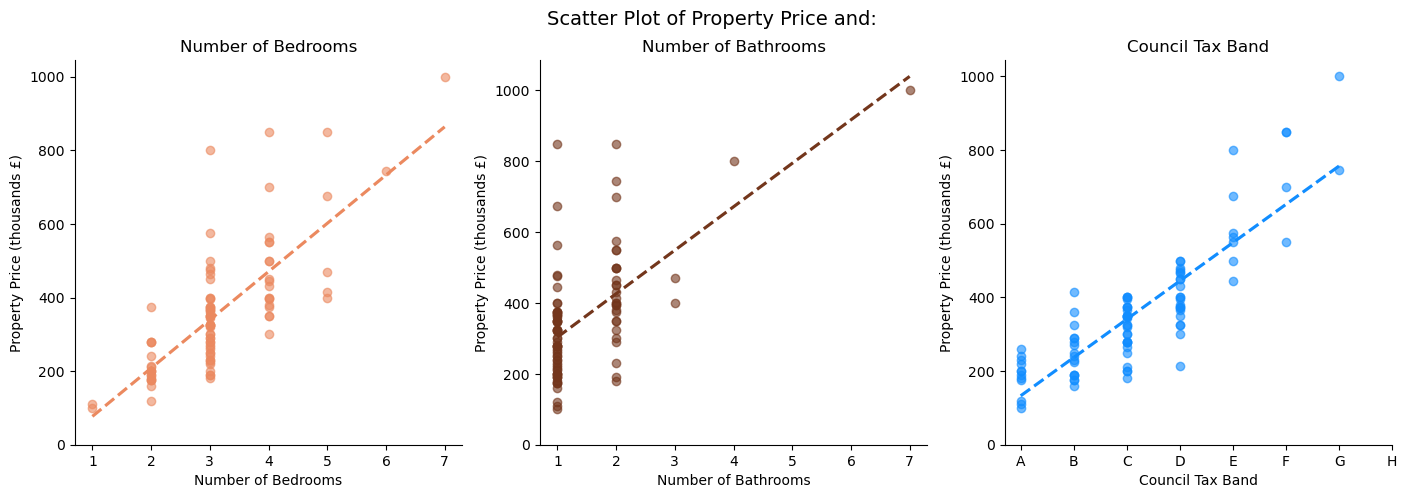

<Figure size 800x600 with 0 Axes>

In [143]:
fig, axs = plt.subplots(1,3, figsize = (17,5))

# Plot names
scatter_name = ['Number of Bedrooms',
                'Number of Bathrooms',
                'Council Tax Band']

# Regression plotss
price_tick_reg = [p for p in range(0, 1000001, 200000)]
price_tick_tax = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']


plt.figure(figsize=(8, 6))

# Visualise the plots
for i, (var, clr, name)  in enumerate(zip(['no_bed', 'no_bath', 'tax_band_encoded'], ['#EB895F', '#73361C', '#118DFF'], scatter_name)):
    sns.regplot(x = var, y='price', data=df_corr, color = clr,
            scatter_kws={'alpha': 0.6},   # Customize scatter points
            line_kws={'linestyle': '--'},  # Dashed regression line
            ax = axs[i],
            ci=None)  # Remove confidence interval)
    axs[i].set_ylabel('Property Price (thousands £)')
    axs[i].set_xlabel(name)
    axs[i].set_title(name)
    axs[i].set_yticks(price_tick_reg, labels=[p for p in range(0, 1001, 200)])
    # Remove top and right spines
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)    
    if var == 'tax_band_encoded':
        axs[i].set_xticks([p for p in range(1, 9, 1)] ,price_tick_tax)


fig.suptitle('Scatter Plot of Property Price and:', fontsize = 14);

In [79]:
# Calculate correlations of Council tax band vs. price
spearman_corr, _ = stats.spearmanr(df_corr['price'], df_corr['tax_band_encoded'])
pearson_corr, _ = stats.pearsonr(df_corr['price'], df_corr['tax_band_encoded'])
kendall_corr, _ = stats.kendalltau(df_corr['price'], df_corr['tax_band_encoded'])

print("Spearman's Correlation:", spearman_corr)
print("Pearson's Correlation:", pearson_corr)
print("Kendall's Tau Correlation:", kendall_corr)

Spearman's Correlation: 0.832981731805082
Pearson's Correlation: 0.8617456807455822
Kendall's Tau Correlation: 0.7097918605227405


In [80]:
# Calculate VIF for each feature

# Remove the dependent variable (Price)
X_vif = df_corr.drop(columns=['price', 'type_Detached', 'tenure_Freehold']).astype(float)

# Add a constant for intercept
X_vif = sm.add_constant(X_vif)

# Calculate VIF for each predictor
vif = pd.DataFrame()
vif['Feature'] = X_vif.columns
vif['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print(vif)

               Feature        VIF
0                const  88.943251
1               no_bed   3.860427
2              no_bath   2.254971
3               garden   2.060531
4              parking   1.488249
5   to_nearest_station   1.220013
6    to_nearest_school   1.420853
7     tax_band_encoded   3.831388
8            type_Flat   7.889736
9           type_Other   1.974503
10  type_Semi-Detached   2.618956
11       type_Terraced   4.418090
12    tenure_Leasehold   5.302584


## 7. Linear Regression Model for Price Prediction
<a name="7"></a>

#### Encode the categorical variables and Outliers processing:

In [81]:
# the data frame with variables used for linear regression
df_lg = df[['price', 'type', 'no_bed', 'no_bath', 'garden', 'parking','new_home','tenure','to_nearest_station','to_nearest_school', 'tax_band']]

# Calculate IQR within each property type
Q1 = df_lg.groupby('no_bed')['price'].transform('quantile', 0.25)
Q3 = df_lg.groupby('no_bed')['price'].transform('quantile', 0.75)
IQR = Q3 - Q1

# Define stricter bounds for far outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out far outliers
df_lg = df_lg[(df_lg['price'] >= lower_bound) & (df_lg['price'] <= upper_bound)]


# Calculate IQR within each property type
Q1_bath = df_lg.groupby('no_bath')['price'].transform('quantile', 0.25)
Q3_bath = df_lg.groupby('no_bath')['price'].transform('quantile', 0.75)
IQR_bath = Q3_bath - Q1_bath

# Define stricter bounds for far outliers
lower_bound_bath = Q1_bath - 2 * IQR_bath
upper_bound_bath = Q3_bath + 2 * IQR_bath

# Filter out far outliers
df_lg = df_lg[(df_lg['price'] >= lower_bound_bath) & (df_lg['price'] <= upper_bound_bath)]

#drop the rows with NaNs in 'tenure'
df_lg.dropna(inplace=True)


# Drop rows where tax_band is 'TBC'
df_lg  = df_lg [df_lg ['tax_band'] != 'TBC']
df_lg  = df_lg.reset_index(drop = True)

# Create the encoder
encoder_reg = OneHotEncoder(drop='first', sparse_output=False)  # Set drop='first' to drop the first category as baselines
encoded_data_reg = encoder_reg.fit_transform(df_lg[['type','garden', 'parking', 'new_home', 'tenure']])
encoded_df_reg = pd.DataFrame(encoded_data_reg, columns=encoder_reg.get_feature_names_out(['type','garden', 'parking', 'new_home', 'tenure']))
df_reg = pd.concat([df_lg.drop(columns=['type','garden', 'parking', 'new_home', 'tenure']), encoded_df_reg], axis=1)

# Apply the mapping
df_reg['tax_band_encoded'] = df_reg['tax_band'].map(tax_band_mapping)
df_reg.drop(columns='tax_band', inplace=True)

### Train the Initial Linear Regression Model with all predictor variables:

In [82]:
training_predictors = ['no_bed', 'no_bath', 'garden_True', 'parking_True',
                       'to_nearest_station', 'to_nearest_school',	'type_Flat', 
                       'type_Other',	'type_Semi-Detached',	'type_Terraced',
                       'tenure_Leasehold', 'tax_band_encoded']

def linear_reg(dependent, indipendent):
    ''' This function fits the Linear Regression OLS model

    Arguments:
        dependent -- dependent (predicted) variariable
        indipendent -- independent (predictor) variariables

    Returns:
        summary table of the trained model
    '''
        
    X_OLS = indipendent
    y_OLS = dependent

    # OLS model
    X_OLS = sm.add_constant(X_OLS)
    model_OLS = sm.OLS(y_OLS,X_OLS)
    results_OLS = model_OLS.fit()

    return results_OLS.summary()

linear_reg(df_reg['price'], df_reg[training_predictors])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     53.80
Date:                Sun, 22 Dec 2024   Prob (F-statistic):           9.65e-31
Time:                        12:56:53   Log-Likelihood:                -1019.9
No. Observations:                  84   AIC:                             2066.
Df Residuals:                      71   BIC:                             2097.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -3.062e+04   5.03e+04     -0.608      0.545   -1.31e+05    6.98e+04
no_bed              2.914e+04    1.3e+04      2.236      0.028    3153.894    5.51e+04
no_bath             4.941e+04   1.16e+04      4.247      0.000    2.62e+04    7.26e+04
garden_True        -1425.9645    2.8e+04     -0.051      0.959   -5.72e+04    5.43e+04
parking_True        2.842e+04   2.14e+04      1.327      0.189   -1.43e+04    7.11e+04
to_nearest_station   3.73e+04   1.41e+04      2.654      0.010    9277.287    6.53e+04
to_nearest_school   4.748e+04   5.34e+04      0.889      0.377    -5.9e+04    1.54e+05
type_Flat          -6.223e+04   4.97e+04     -1.252      0.215   -1.61e+05    3.69e+04
type_Other         -8217.8988   4.27e+04     -0.192      0.848   -9.34e+04     7.7e+04
type_Semi-Detached   566.3618   1.93e+04      0.029      0.977   -3.79e+04    3.91e+04
type_Terraced      -1.243e+04   2.49e+04     -0.499      0.619   -6.21e+04    3.72e+04
tenure_Leasehold   -4.971e+04   4.17e+04     -1.192      0.237   -1.33e+05    3.35e+04
tax_band_encoded    5.288e+04   7872.322      6.717      0.000    3.72e+04    6.86e+04
==============================================================================
Omnibus:                        0.412   Durbin-Watson:                   2.229
Prob(Omnibus):                  0.814   Jarque-Bera (JB):                0.145
Skew:                           0.090   Prob(JB):                        0.930
Kurtosis:                       3.094   Cond. No.                         70.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Train the Linear Regression Model with significant variables:

In [83]:
#parsimonious model training predictors
pars_training_predictors = ['no_bed', 'no_bath', 'to_nearest_station', 'tax_band_encoded']

# Train the parsimounious Model
linear_reg(df_reg['price'], df_reg[pars_training_predictors])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     133.8
Date:                Sun, 22 Dec 2024   Prob (F-statistic):           2.31e-34
Time:                        12:56:53   Log-Likelihood:                -1030.9
No. Observations:                  84   AIC:                             2072.
Df Residuals:                      79   BIC:                             2084.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -6.998e+04   2.23e+04     -3.143      0.002   -1.14e+05   -2.57e+04
no_bed              5.748e+04   9412.672      6.107      0.000    3.87e+04    7.62e+04
no_bath             2.776e+04   9658.803      2.875      0.005    8539.109     4.7e+04
to_nearest_station  1.666e+04   1.41e+04      1.180      0.242   -1.14e+04    4.48e+04
tax_band_encoded     5.74e+04   5683.424     10.099      0.000    4.61e+04    6.87e+04
==============================================================================
Omnibus:                        1.117   Durbin-Watson:                   2.353
Prob(Omnibus):                  0.572   Jarque-Bera (JB):                1.202
Skew:                           0.237   Prob(JB):                        0.548
Kurtosis:                       2.655   Cond. No.                         20.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Drop `to_nearest_station` and train the final model again:

In [84]:
#parsimonious model training predictors
pars_training_predictors = ['no_bed', 'no_bath', 'tax_band_encoded']

# Train the parsimounious Model
linear_reg(df_reg['price'], df_reg[pars_training_predictors])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     177.1
Date:                Sun, 22 Dec 2024   Prob (F-statistic):           3.16e-35
Time:                        12:56:53   Log-Likelihood:                -1031.6
No. Observations:                  84   AIC:                             2071.
Df Residuals:                      80   BIC:                             2081.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                -6e+04   2.06e+04     -2.906      0.005   -1.01e+05   -1.89e+04
no_bed            5.812e+04   9419.988      6.170      0.000    3.94e+04    7.69e+04
no_bath           2.691e+04   9655.240      2.787      0.007    7695.663    4.61e+04
tax_band_encoded  5.786e+04   5683.434     10.181      0.000    4.66e+04    6.92e+04
==============================================================================
Omnibus:                        1.795   Durbin-Watson:                   2.368
Prob(Omnibus):                  0.408   Jarque-Bera (JB):                1.814
Skew:                           0.305   Prob(JB):                        0.404
Kurtosis:                       2.618   Cond. No.                         18.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Explanation of Output
- Coefficient: Shows the intercept and slope for the regression line.
- P-value: Tests if coefficients significantly differ from zero.
- R-squared: Indicates how well the independent variable explains the variation in the dependent variable.

In [85]:
pars_training_predictors_2 = ['no_bed', 'no_bath', 'tax_band_encoded']


# Using Sckiktlearn to train and later score the model instead
X = df_reg[pars_training_predictors_2]
y = df_reg['price']

#Linear Regression model
model_sckit1 = LinearRegression()
model_sckit1.fit(X, y)

# Making predictions
y_pred = model_sckit1.predict(X)

# Output results
print("1. Intercept:", model_sckit1.intercept_)
print("2. Coefficient:", model_sckit1.coef_)
print("3. Mean Squared Error:", mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)
print("4. R^2 Score:", r2)
print("5. Adjusted R^2:", (1 - (1 - r2) * ((len(df_reg) - 1) / (len(df_reg) - 4 - 1))))


1. Intercept: -59998.3313135106
2. Coefficient: [58124.36809973 26910.20237131 57863.93085274]
3. Mean Squared Error: 2719537627.4838495
4. R^2 Score: 0.8691450894819135
5. Adjusted R^2: 0.8625195243923901


### Score the separate set of 30 properties to the derived Model:

In [86]:
# Keeping only appropriate columns
df_test = df_test[['price', 'no_bed','to_nearest_station','to_nearest_school', 'type', 'no_bath', 'tenure', 'tax_band']]

#drop the 4 rows with NaNs
df_test.dropna(inplace=True)
# Drop rows where tax_band is 'TBC'
df_test = df_test[df_test['tax_band'] != 'Band: TBC']
df_test = df_test.reset_index(drop = True)

# Get dummies
# Create the encoder
encoder_test = OneHotEncoder(drop='first', sparse_output=False)  # Set drop='first' to drop the first category as baselines
encoded_data_test = encoder_test.fit_transform(df_test[['tenure', 'type']])
encoded_df_test = pd.DataFrame(encoded_data_test, columns=encoder_test.get_feature_names_out(['tenure', 'type']))


# Mapping of tax bands to numeric values
# Apply the mapping
df_test['tax_band_encoded'] = df_test['tax_band'].map(tax_band_mapping)
df_test.drop(columns='tax_band', inplace=True)

df_test = pd.concat([df_test.drop(columns=['tenure', 'type']), encoded_df_test], axis=1)

x_test = df_test.drop(columns='price')
# adding the columns accordingly to the model
x_test['type_Other'] = 0

# Correct the column order  'no_bed', 'no_bath', 'to_nearest_station', 'to_nearest_school',	'type_Flat', 'type_Other',	'type_Semi-Detached',	'type_Terraced', 'tenure_Leasehold', 'tax_band_encoded'
x_test = x_test[pars_training_predictors]


In [87]:
# Score the Separate Test Data to the trained Model
actual_price = df_test['price']
# Predictions
predict_price = model_sckit1.predict(x_test)
# Output results
print("1. Intercept:", model_sckit1.intercept_)
print("2. Coefficient:", model_sckit1.coef_)
print("3. Mean Squared Error:", mean_squared_error(actual_price, predict_price))
r2 = r2_score(actual_price, predict_price)
print("4. R^2 Score:", r2)
print("5. Adjusted R^2:", (1 - (1 - r2) * ((len(df_reg) - 1) / (len(df_reg) - 4 - 1))))

1. Intercept: -59998.3313135106
2. Coefficient: [58124.36809973 26910.20237131 57863.93085274]
3. Mean Squared Error: 2035221984.4719038
4. R^2 Score: 0.8854396495511934
5. Adjusted R^2: 0.8796391254778361


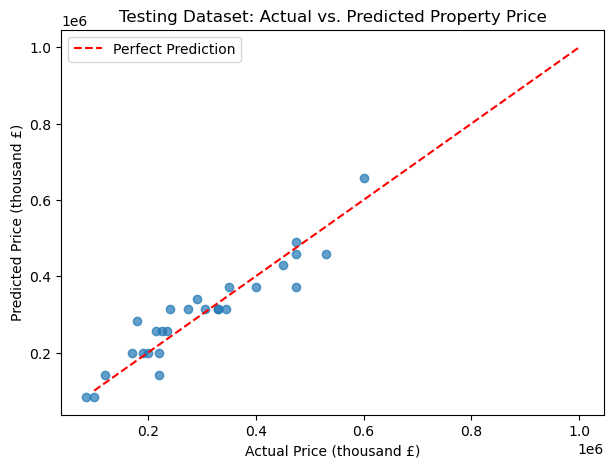

In [88]:
plt.figure(figsize=(7, 5))
plt.scatter(actual_price, predict_price, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--', label = 'Perfect Prediction')  # Line for perfect prediction  
plt.xlabel('Actual Price (thousand £)')
plt.ylabel('Predicted Price (thousand £)')
plt.title('Testing Dataset: Actual vs. Predicted Property Price')
plt.legend(loc='upper left')
plt.show()

#### Conclusion: 
The Final Model with high adjusted R2 in both training and testing sets of 0.87 and 0.88, with the predicted value aligns closely with their actual values. Thus, there are strong confidence in the performance of the property price prediction model. 

### Residual analysis for the final (most parsimonious) Model

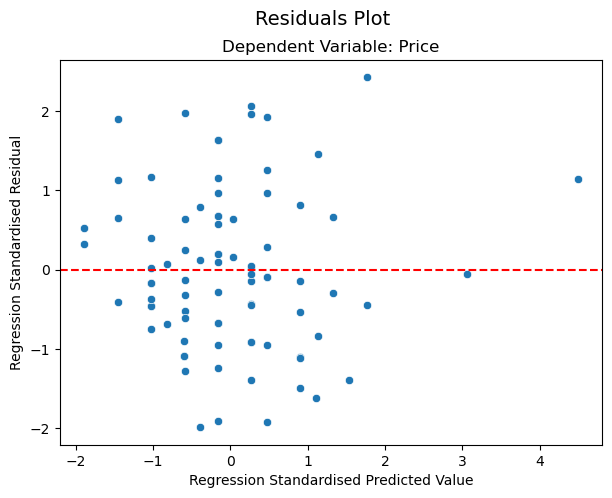

In [89]:
# Predict values and calculate residuals
residuals = y - y_pred

# Standardize the residuals
standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)

# Standardize the predicted values
standardized_predicted_values = (y_pred - np.mean(y_pred)) / np.std(y_pred)

# Residual plot
plt.figure(figsize=(7, 5))
sns.scatterplot(x=standardized_predicted_values, y=standardized_residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Regression Standardised Predicted Value')
plt.ylabel('Regression Standardised Residual')
plt.suptitle('Residuals Plot', fontsize = 14)
plt.title('Dependent Variable: Price')
plt.show()

Residual Normality Testing:

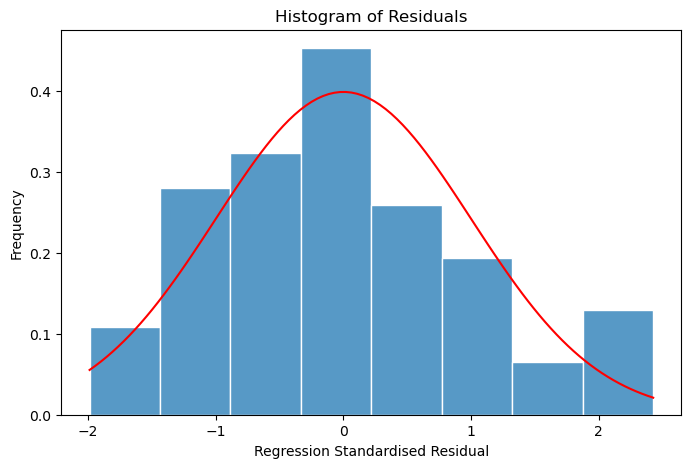

In [90]:
# Histogram of residuals
# Example Data: Replace 'df["price"]' with your actual column

# Fit a normal distribution to the data
mean_res = np.mean(standardized_residuals)
std_dev_res = np.std(standardized_residuals)

# Generate x values for the normal curve
x_res = np.linspace(min(standardized_residuals), max(standardized_residuals), 100)

# Calculate the y values for the normal distribution
y_res = stats.norm.pdf(x_res, mean_res, std_dev_res)
plt.figure(figsize=(8, 5))
sns.histplot(standardized_residuals, kde=False, stat='density', edgecolor = 'white')
# Plot the normal curve
plt.plot(x_res, y_res, color='red', label="Normal Curve")
plt.xlabel('Regression Standardised Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

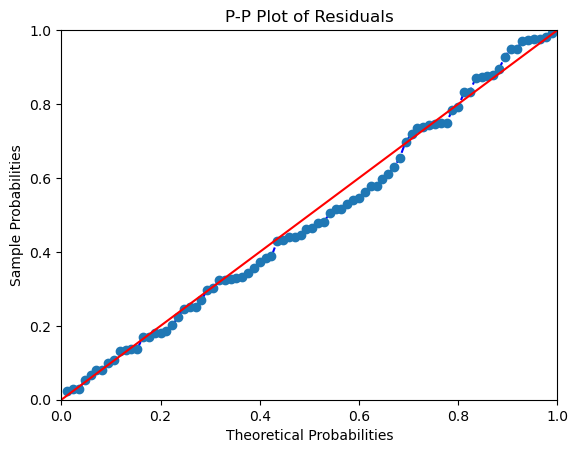

In [91]:
# Compute the standardized residuals
residuals_standardized = (residuals - np.mean(residuals)) / np.std(residuals)

# Create the P-P plot
sm.ProbPlot(residuals_standardized).ppplot(line='45', linestyle = '--')

# Add title
plt.title("P-P Plot of Residuals")
plt.show()

In [92]:
stat, p_value = stats.shapiro(residuals_standardized)
print("Shapiro-Wilk Test: p-value =", p_value)

if p_value > 0.05:
    print("Residuals are normally distributed.")
else:
    print("Residuals are NOT normally distributed.")

Shapiro-Wilk Test: p-value = 0.308242419177854
Residuals are normally distributed.


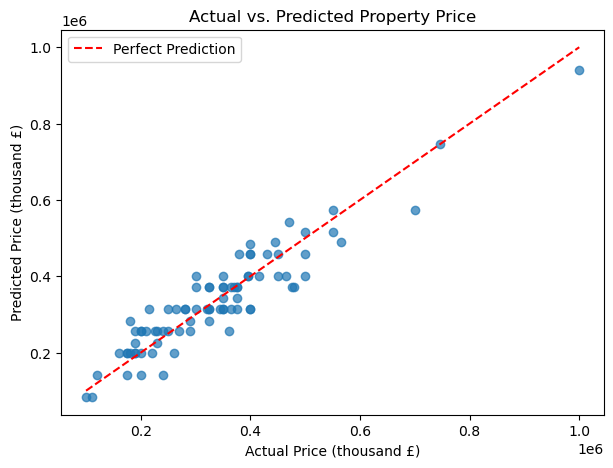

In [93]:
plt.figure(figsize=(7, 5))
plt.scatter(y, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--', label = 'Perfect Prediction')  # Line for perfect prediction  
plt.xlabel('Actual Price (thousand £)')
plt.ylabel('Predicted Price (thousand £)')
plt.title('Actual vs. Predicted Property Price')
plt.legend(loc='upper left')
plt.show()

Conclusion: The Residuals satisfy all 4 assumptions of resiuals regarding Linearity, Independence, Homoscedasticity, and Normarlity.

### The Final Property Price Prediction Model

The Price of a Property in Birmingham's B28 Area can be estimated:

$$\text{Price} = 58124.3 \cdot \text{no\_bed} + 26910.2 \cdot \text{no\_bath} + 57863.9 \cdot \text{tax\_band\_encoded} - 59998.33 $$

Where:
- `no_bed`: Number of Bedrooms of that particular property.
- `no_bath`: Number of Bathrooms.
- `tax_bad_encoded`: UK Council Tax Bad, 1-8 correspond to A-H bands
